<div class="row">
  <div class="col-sm-8">
     <center>
        <h1>
        IA 702 - Probalistic Models and Machine Learning<br>
            <br>
        TP4 - Modèles probabilistes discriminants pour le Machine Learning
        <hr class="bg-light" />
            <i>Alexandre LE BRIS<br></i>
            <i>MS IA - 21/22<br></i>
        </h1>
    </center>
  </div>
      <div class="col-sm-4">
          <img src="https://s3-eu-west-1.amazonaws.com/assets.atout-on-line.com/images/ingenieur/Fiches_Ecoles/telecom_paristech.jpg" alt="drawing" width="200"/>
  </div>
</div>

***
***

In [33]:
# Import des packages
import numpy as np
import pandas as pd
import torch, torchvision
from torch import optim
import matplotlib.pyplot as plt
import seaborn as sns
from TP4_functions.load_conll2000 import load_conll2000_glove
from torch.nn import Module, Parameter
import warnings

warnings.filterwarnings("ignore")
sns.set_theme()

## La fonction softmax

In [19]:
# Implémentation de la fonction softmax valable en vectoriel
def softmax(x):
    if len(x.size()) == 1:
        x = x.view(1, -1)
    
    x = x - torch.max(x, axis=1).values.view(-1, 1)
    x = torch.exp(x)
    total = torch.sum(x, axis=1)
    
    return x / total.view(-1, 1)

In [31]:
# Test de la fonction Softmax
x = torch.tensor([5., 1., 2., -1.])
print(f"Pour les valeurs d'entrées {x.numpy().tolist()}, la fonction softmax retourne :")
print(softmax(x))

Pour les valeurs d'entrées [5.0, 1.0, 2.0, -1.0], la fonction softmax retourne :
tensor([[0.9341, 0.0171, 0.0465, 0.0023]])


In [32]:
x = torch.tensor([200005., 200003., 200000., 200000.])
print(f"Pour les valeurs d'entrées {x.numpy().tolist()}, la fonction softmax retourne :")
print(softmax(x))

Pour les valeurs d'entrées [200005.0, 200003.0, 200000.0, 200000.0], la fonction softmax retourne :
tensor([[0.8705, 0.1178, 0.0059, 0.0059]])


## Classification de chiffres avec la régression logistique

In [101]:
# Import des données
dataset = torchvision.datasets.MNIST("./", download = True)

# Découpage en set d'entraînement et de test (50, 50)
train_set_y, train_set_x = dataset.data[:50000], dataset.targets[:50000]
test_set_y, test_set_x = dataset.data[50000:], dataset.targets[50000:]

# Standardisation des données et découpage des échantillons entre
# variables explicatives (x) et variable à expliquer(y)
train_set_y = (train_set_y.view(50000, -1) + 0.0)
mean_train, std_train = torch.mean(train_set_y), torch.std(train_set_y)
train_set_y = (train_set_y - mean_train) / std_train

train_set = []
for i in range(50000):
    train_set.append([train_set_x[i], train_set_y[i]])

test_set_y = (test_set_y.view(10000, -1) + 0.0)
mean_test, std_test = torch.mean(test_set_y), torch.std(test_set_y)
test_set_y = (test_set_y - mean_test)/std_test
    
test_set = []    
for i in range(10000):
    test_set.append([test_set_x[i], test_set_y[i]])

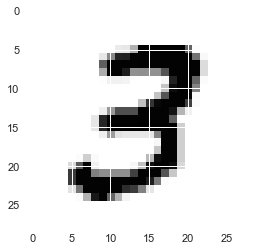

tensor(3)


In [102]:
# Affichage d'un exemple
exemple = 7
plt.imshow(train_set[exemple][1].view(28, 28), cmap='Greys')
plt.show()
print(train_set[exemple][0])

In [103]:
# Import des paramètres initiaux
W_lr = torch.load("TP4_functions/W_lr.pt").requires_grad_(True)
b_lr = torch.load("TP4_functions/b_lr.pt").requires_grad_(True)

In [104]:
# Fonction pour calculer la sortie de la régression logistique
def g(x, W, b):
    val = x @ W.T + b
    return softmax(val)

# Définition de la fonction de coût
def L(g, train_set, W, b):
    ce = 0
    for line in train_set:
        x = line[0]
        y = line[1]
        ce -= torch.log(g(y, W, b)[0][x])
    
    ce /= len(train_set)
    return ce

# Définition des hyperparamètres
alpha = 5e-5
batch_size = 256
K = 1000
optimizer = optim.Adam([W_lr, b_lr], lr=alpha)

# Initialisation des variables utilisées dans la boucle
list_L = torch.zeros(K)
dict_score = {}
train_set = np.array(train_set, dtype='object')
train_size = len(train_set)

# Affichage de la Loss pour les 100 premiers exemples du train set
loss = L(g, train_set[:100], W_lr, b_lr)
print(f"La valeur de la Loss pour les 100 premiers exemples du train set est : \
{float(loss.item()):.4f}.\n")

for k in range(1, K+1):
    # Sélection des échantillons pour le batch
    indices = np.random.choice(train_size, batch_size)
    
    # Calcul de la loss (forward propagation) et apprentissage (backward propagation) 
    optimizer.zero_grad()
    loss = L(g, train_set[indices], W_lr, b_lr)
    loss.backward()
    optimizer.step()
    
    list_L[k-1] = loss.item()
    
    # Affichage de la loss sur le batch et du score sur le test toutes les 50 itérations
    if k % 50 == 0 or k==1:
        print(f"Itération : {k}")
        print(f"Valeur de la fonction Loss : {float(list_L[k-1]):.4f}")
        
        # Calcul du score
        success = 0
        for line in test_set:
            x = line[0]
            y = line[1]
            if g(y, W_lr, b_lr).argmax() == x:
                success += 1
        score = success / len(test_set)
        dict_score[k] = score
        print(f"Score sur le set de test : {score:.4f}")
        print("*************************************\n")

La valeur de la Loss pour les 100 premiers exemples du train set est : 2.4652.

Itération : 1
Valeur de la fonction Loss : 2.5089
Score sur le set de test : 0.0753
*************************************

Itération : 50
Valeur de la fonction Loss : 2.1480
Score sur le set de test : 0.2755
*************************************

Itération : 100
Valeur de la fonction Loss : 1.8026
Score sur le set de test : 0.4696
*************************************

Itération : 150
Valeur de la fonction Loss : 1.6019
Score sur le set de test : 0.5982
*************************************

Itération : 200
Valeur de la fonction Loss : 1.3886
Score sur le set de test : 0.6758
*************************************

Itération : 250
Valeur de la fonction Loss : 1.2215
Score sur le set de test : 0.7342
*************************************

Itération : 300
Valeur de la fonction Loss : 1.1302
Score sur le set de test : 0.7654
*************************************

Itération : 350
Valeur de la fonction Loss : 1.0

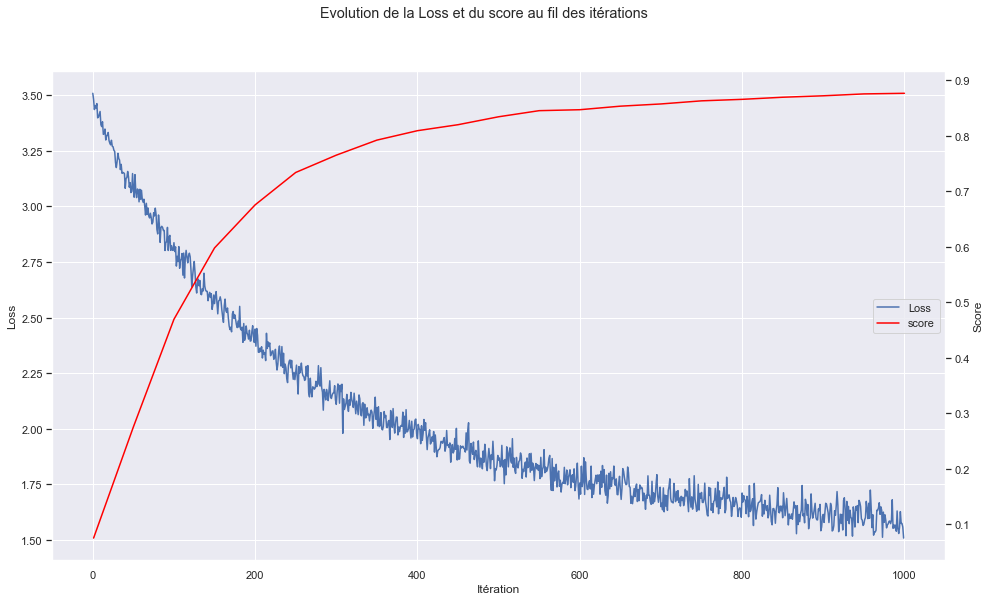

In [105]:
# Affichage des courbes de Loss et de score
fig, ax = plt.subplots(figsize=(16, 9))

plot1 = ax.plot(list_L + 1, label="Loss")

ax2=ax.twinx()
plot2 = ax2.plot(dict_score.keys(), dict_score.values(),
                 color='red', label='score')
ax2.grid(False)

lns = plot1 + plot2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=7)

ax.set_xlabel("Itération")
ax.set_ylabel('Loss')
ax2.set_ylabel('Score')

plt.suptitle('Evolution de la Loss et du score au fil des itérations')

plt.show()

**Le score final en fin d'entraînement atteint presque les 88 %.**

## Maximum Entropy Markov Model pour le POS tagging 

In [84]:
# Import des données des datasets
path = "TP4_functions/"
omega_X, train_set, test_set = load_conll2000_glove(path)

In [85]:
# Indexation des tags
ind2tag = {i: omega_X[i] for i in range(len(omega_X))}
tag2ind = {omega_X[i]: i for i in range(len(omega_X))}

# Mise en forme du set d'entraînement et conversions des tags en index
y_train_set = np.array([train_set[i][1] for i in range(len(train_set))], dtype='object')
x_train_set = np.array([torch.tensor([tag2ind[tag] for tag in train_set[i][0]]).view(-1, 1)
                        for i in range(len(train_set))], dtype='object')

In [95]:
# Import des paramètres initiaux
W_lr1 = torch.load("TP4_functions/W_lr1.pt").requires_grad_(True)
b_lr1 = torch.load("TP4_functions/b_lr1.pt").requires_grad_(True)
W_lr2 = torch.load("TP4_functions/W_lr2.pt").requires_grad_(True)
b_lr2 = torch.load("TP4_functions/b_lr2.pt").requires_grad_(True)

In [92]:
# On définit le réseau de neurones en tant que modèle à travers la classe Module
class MEMM(Module):
    
    # On instancie les paramètres du modèles à travers le constructeur 
    def __init__(self):
        super().__init__()
        self.W_lr1 = Parameter(torch.load("TP4_functions/W_lr1.pt"))
        self.W_lr1.requires_grad_(True)
        self.b_lr1 = Parameter(torch.load("TP4_functions/b_lr1.pt"))
        self.b_lr1.requires_grad_(True)
        self.W_lr2 = Parameter(torch.load("TP4_functions/W_lr2.pt"))
        self.W_lr2.requires_grad_(True)
        self.b_lr2 = Parameter(torch.load("TP4_functions/b_lr2.pt"))
        self.b_lr2.requires_grad_(True)

    # On définit la fonction de propagation Forward du réseau de neurones
    def forward(self, y):     
        # Initialisation de la matrice pour permettre la récursion forward
        size_x = len(y)             # Nombre de tags dans la phrase
        size_tags = len(omega_X)    # Nombre de tags différents
        alphas = torch.zeros(size_x, size_tags)
        
        # 1ère étape de la récursion avec calcul de L1
        L1 = (y[0] @ self.W_lr1.T + self.b_lr1)
        alphas[0, :] = softmax(L1)
        
        # Exécution de la récursion avec les calculs des L2
        for i in range(size_x - 1):
            temp1 = torch.diag(torch.ones(size_tags)) # Indication de l'index du tag
            temp2 = y[i+1].repeat(size_tags, 1)       
            y_temp = torch.cat((temp1, temp2), 1)     # A chaque tag, on repète l'observation x
            L2 = (y_temp @ self.W_lr2.T + self.b_lr2)
            alphas[i+1, :] = alphas[i, :].clone() @ softmax(L2)

        return alphas

# Calcul de la fonction de perte
def ceLoss(alphas, x):
    ce = 0
    count = 0
    for i in range(len(x)):
        proba_y = torch.gather(alphas[i], 1, x[i])        
        ce -= torch.log(proba_y).sum()
        count += len(proba_y)
    
    ce /= count
    return ce

In [96]:
# Initialisation du modèle et des hyperparamètres
step = 5e-4
batch_size = 32
K = 1000
model = MEMM()
optimizer = optim.Adam(model.parameters(), lr=step)

# Initialisation des variables utilisées dans la boucle
train_size = len(train_set)
list_L = torch.zeros(K)
dict_score = {}

# Affichage de la Loss pour les 10 premiers exemples du train set
alphas = [model(y) for y in y_train_set[:10]]
loss = ceLoss(alphas, x_train_set[:10])
print(f"La valeur de la Loss pour les 10 premiers exemples du train set est : \
{float(loss.item()):.4f}.\n")

for k in range(1, K+1):
    # Sélection des échantillons pour le batch
    indices = np.random.choice(train_size, batch_size)
    
    # Calcul de la loss (forward propagation) et apprentissage (backward propagation)
    optimizer.zero_grad()
    alphas = [model(y) for y in y_train_set[indices]]
    loss = ceLoss(alphas, x_train_set[indices])
    loss.backward()
    optimizer.step()
    
    list_L[k-1] = loss.item()
    
    # Affichage de la loss sur le batch et du score sur le test toutes les 50 itérations
    if k % 50 == 0 or k == 1:
        print(f"Itération : {k}")
        print(f"Valeur de la fonction Loss : {float(list_L[k-1]):.4f}")
        
        # Calcul du score
        success = 0
        count = 0
        for x, y in test_set:
            x = torch.tensor([tag2ind[tag] for tag in x])
            x_predict = model(y).argmax(axis=1)
            success += (x == x_predict).sum()
            count += len(x)
        score = success / count
        dict_score[k] = score
        print(f"Score sur le set de test : {score:.4f}")
        print("*************************************\n")

La valeur de la Loss pour les 10 premiers exemples du train set est : 2.8965.

Itération : 1
Valeur de la fonction Loss : 2.9033
Score sur le set de test : 0.0067
*************************************

Itération : 50
Valeur de la fonction Loss : 2.3913
Score sur le set de test : 0.2960
*************************************

Itération : 100
Valeur de la fonction Loss : 2.0973
Score sur le set de test : 0.4553
*************************************

Itération : 150
Valeur de la fonction Loss : 1.9296
Score sur le set de test : 0.5175
*************************************

Itération : 200
Valeur de la fonction Loss : 1.6863
Score sur le set de test : 0.5792
*************************************

Itération : 250
Valeur de la fonction Loss : 1.5538
Score sur le set de test : 0.6175
*************************************

Itération : 300
Valeur de la fonction Loss : 1.4662
Score sur le set de test : 0.6362
*************************************

Itération : 350
Valeur de la fonction Loss : 1.42

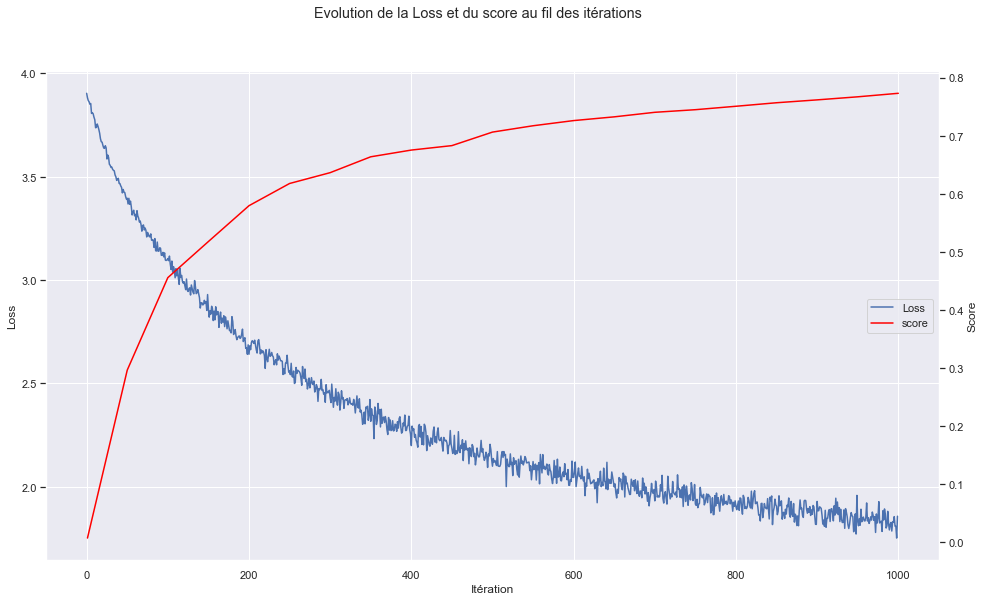

In [97]:
# Affichage des courbes de Loss et de score
fig, ax = plt.subplots(figsize=(16, 9))

plot1 = ax.plot(list_L + 1, label="Loss")

ax2=ax.twinx()
plot2 = ax2.plot(dict_score.keys(), dict_score.values(),
                 color='red', label='score')
ax2.grid(False)

lns = plot1 + plot2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=7)

ax.set_xlabel("Itération")
ax.set_ylabel('Loss')
ax2.set_ylabel('Score')

plt.suptitle('Evolution de la Loss et du score au fil des itérations')

plt.show()

**Le score final en fin d'entraînement atteint les 77 %.**

## Bac à sable

In [9]:
def forward(y, W_lr1, b_lr1, W_lr2, b_lr2):
    size_y = len(y)
    size_tags = len(omega_X)
    #alpha = torch.zeros(size_y, size_tags)
    alpha = []

    L1 = (y[0] @ W_lr1.T + b_lr1)

    #alpha[0, :] = softmax(L1)
    alpha.append(softmax(L1))
    for i in range(size_y - 1):
        x_temp = torch.diag(torch.ones(size_tags))
        y_temp = y[i+1].repeat(size_tags, 1)
        x_y = torch.cat((x_temp, y_temp), 1) 
        L2 = (x_y @ W_lr2.T + b_lr2)
        #alpha[i+1, :] = alpha[i, :].clone() @ softmax(L2)
        alpha.append(alpha[-1] @ softmax(L2))
        
    return torch.stack(alpha, dim=1)[0]

In [14]:
def L(f, train_set, W_lr1, b_lr1, W_lr2, b_lr2):
    ce = 0
    count = 0
    for line in train_set:
        x = torch.tensor([tag2ind[tag] for tag in line[0]]).view(-1, 1)
        y = line[1]
        proba_y = torch.gather(f(y, W_lr1, b_lr1, W_lr2, b_lr2), 1, x)
        ce -= torch.log(proba_y).sum()
        count += len(proba_y)
    
    ce /= count
    return ce

tensor([[13],
        [ 2],
        [ 3],
        [13],
        [ 6],
        [ 4],
        [ 6],
        [ 8],
        [ 6],
        [ 3],
        [ 0],
        [13],
        [ 2],
        [13],
        [13],
        [ 2],
        [ 5],
        [10],
        [ 0],
        [ 2],
        [13],
        [13],
        [10],
        [ 6],
        [ 8],
        [ 6],
        [ 3],
        [ 0],
        [13],
        [ 2],
        [ 5],
        [ 7],
        [ 5],
        [ 8],
        [ 0],
        [13],
        [10]])
tensor([[ 7.7302e-02, -1.8937e-04,  8.3870e-01,  ..., -7.2153e-01,
          1.1554e-01,  8.8954e-01],
        [ 8.5703e-02, -2.2201e-01,  1.6569e-01,  ..., -7.4273e-02,
          7.5808e-01, -3.4243e-01],
        [-3.8194e-02, -2.4487e-01,  7.2812e-01,  ..., -1.4590e-01,
          8.2780e-01,  2.7062e-01],
        ...,
        [ 4.5092e-01, -4.6885e-01, -2.3471e-01,  ...,  2.4301e-01,
         -3.6966e-01, -2.3181e-01],
        [-1.7509e-01,  7.3102e-01,  1.2163e+00,  ..., -3

tensor([[-6.7422e-01, -1.8842e-01, -3.2851e-01, -2.8052e-01, -6.5667e-01,
         -4.6870e-01,  2.6508e-01,  5.2278e-01, -2.5419e-01,  1.5326e-01,
          1.2792e+00, -4.1621e-01,  1.4411e-01, -2.3093e-01, -9.5321e-01,
          5.9247e-01,  1.2653e-01, -2.3403e-01, -5.3845e-01,  2.0168e-01,
         -3.5275e-01,  1.2035e-01,  5.9600e-01,  6.9286e-01,  5.7741e-01,
          2.6366e-01,  2.1012e-05, -1.7903e-01,  5.4103e-02, -5.4204e-01,
         -1.4384e-01, -6.1504e-01,  4.1755e-01,  8.7516e-02,  2.7318e-02,
          6.8135e-01, -3.1371e-01,  1.0498e+00,  1.8153e-01, -2.5134e-01,
          1.2880e-01,  8.0035e-01, -2.6115e-01,  1.0151e-01, -6.7678e-01,
          9.3767e-01, -5.1234e-01,  1.9349e-01, -3.0634e-02,  5.7282e-01,
         -8.9658e-02,  3.0154e-01, -1.5112e-01, -2.2194e-01, -1.2270e-01,
          4.9237e-01, -4.5538e-01,  2.7828e-01,  6.1004e-01, -5.1329e-01,
          1.2289e+00, -7.4527e-01,  1.1218e-01,  5.3485e-01, -3.7272e-01,
          1.0208e-01,  9.5055e-05,  6.

tensor([[0.9403],
        [0.1570],
        [0.5762],
        [0.4095],
        [0.8005],
        [0.6684],
        [0.8246],
        [0.0555],
        [0.4330],
        [0.4386],
        [0.7485],
        [0.2229],
        [0.0765],
        [0.1075],
        [0.2694],
        [0.6936],
        [0.9232],
        [0.1653],
        [0.4333],
        [0.6640],
        [0.4558],
        [0.7222],
        [0.8965],
        [0.5456],
        [0.2599],
        [0.3243],
        [0.8226],
        [0.8641],
        [0.9151],
        [0.8374],
        [0.9132],
        [0.8200],
        [0.8297],
        [0.9148],
        [0.0743],
        [0.8258]], grad_fn=<GatherBackward>)
tensor([[ 3],
        [13],
        [ 2],
        [13],
        [ 5],
        [ 0],
        [13],
        [ 6],
        [ 6],
        [ 6],
        [ 2],
        [ 2],
        [13],
        [10]])
tensor([[-0.2182,  0.6920,  0.7044,  ..., -0.3797,  0.6828,  0.6388],
        [-0.1448,  0.8591, -0.3064,  ..., -0.5828,  0.9250

tensor(0.7895)
tensor([[ 6],
        [ 2],
        [ 3],
        [ 0],
        [13],
        [ 6],
        [13],
        [ 2],
        [12],
        [ 0],
        [13],
        [10]])
tensor([[-0.3318,  0.3514,  0.1362,  ..., -0.2762,  1.0907, -0.2662],
        [ 0.0857, -0.2220,  0.1657,  ..., -0.0743,  0.7581, -0.3424],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [ 0.7802, -0.4794, -0.8311,  ...,  1.0658, -0.0765, -0.5618],
        [ 0.0225, -0.1006, -0.0597,  ...,  1.0856,  0.4681, -0.2451],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288]])
tensor([[0.0732],
        [0.8712],
        [0.9204],
        [0.5024],
        [0.7246],
        [0.7315],
        [0.6057],
        [0.8240],
        [0.1908],
        [0.3452],
        [0.5069],
        [0.8254]], grad_fn=<GatherBackward>)
tensor([[13],
        [ 6],
        [ 0],
        [ 2],
        [11],
        [12],
        [12],
        [10]])
tensor([[ 1.7132e-01, -4.2

tensor([[0.4030],
        [0.9112],
        [0.6549],
        [0.8114],
        [0.9269],
        [0.1412],
        [0.9116],
        [0.2204],
        [0.2719],
        [0.9203],
        [0.8143],
        [0.4497],
        [0.3547],
        [0.2311],
        [0.9118],
        [0.7358],
        [0.6772],
        [0.7182],
        [0.3506],
        [0.7995],
        [0.9266],
        [0.1618],
        [0.5028],
        [0.4774],
        [0.6501],
        [0.2567],
        [0.4460],
        [0.4150],
        [0.5997],
        [0.7389],
        [0.2460],
        [0.8628],
        [0.3404],
        [0.1665],
        [0.2083],
        [0.1005],
        [0.7643],
        [0.1726],
        [0.1136],
        [0.9002],
        [0.7603],
        [0.7125],
        [0.8814],
        [0.1041],
        [0.8824],
        [0.7030],
        [0.6930],
        [0.7251],
        [0.9253],
        [0.8940],
        [0.0845],
        [0.6479],
        [0.1070],
        [0.8118]], grad_fn=<GatherBackward>)
t

tensor([[10],
        [14],
        [ 6],
        [ 6],
        [ 2],
        [14],
        [ 6],
        [11],
        [12],
        [12],
        [ 6],
        [ 2],
        [ 0],
        [ 2],
        [13],
        [13],
        [ 3],
        [13],
        [10],
        [10],
        [ 5],
        [ 5],
        [ 6],
        [10]])
tensor([[ 0.0927,  0.2024,  0.6939,  ..., -0.5135, -0.2775,  1.1636],
        [-0.0465,  0.6197,  0.5665,  ..., -0.3762, -0.0325,  0.8062],
        [ 0.0536,  0.7082,  0.3917,  ...,  0.1595,  0.2171,  1.0110],
        ...,
        [-0.9590, -0.8911, -0.5904,  ..., -0.0462,  0.1156,  0.6195],
        [ 0.1374,  0.5251,  0.5009,  ..., -0.4302, -0.0161,  0.7184],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288]])
tensor([[0.9124],
        [0.7860],
        [0.5039],
        [0.2255],
        [0.2258],
        [0.1508],
        [0.5769],
        [0.9226],
        [0.8249],
        [0.6803],
        [0.4582],
        [0.8960],
        [0.08

tensor([[ 2],
        [13],
        [10],
        [ 3],
        [13],
        [ 6],
        [ 6],
        [ 5],
        [ 8],
        [ 6],
        [ 5],
        [ 8],
        [12],
        [13],
        [ 6],
        [ 2],
        [ 5],
        [ 5],
        [ 7],
        [ 6],
        [ 3],
        [12],
        [13],
        [13],
        [ 8],
        [ 5],
        [ 2],
        [ 3],
        [13],
        [ 6],
        [ 2],
        [ 5],
        [10]])
tensor([[ 0.0857, -0.2220,  0.1657,  ..., -0.0743,  0.7581, -0.3424],
        [ 0.1048, -0.2015,  0.2076,  ...,  0.5640,  0.0701, -0.2198],
        [-0.1077,  0.1105,  0.5981,  ..., -0.8316,  0.4529,  0.0826],
        ...,
        [-0.2087, -0.1174,  0.2648,  ..., -0.3327,  0.2788, -0.8705],
        [ 0.2483,  0.0979, -0.0143,  ...,  0.0571, -0.0044,  0.6186],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288]])
tensor([[0.9061],
        [0.2269],
        [0.9177],
        [0.9105],
        [0.7339],
        [0.79

tensor([[0.8495],
        [0.3121],
        [0.8009],
        [0.8364],
        [0.7563],
        [0.9131],
        [0.2400],
        [0.9260],
        [0.6076],
        [0.0506],
        [0.7079],
        [0.4350],
        [0.8102],
        [0.1156],
        [0.6879],
        [0.4070],
        [0.8272]], grad_fn=<GatherBackward>)
tensor([[10],
        [13],
        [ 2],
        [ 3],
        [13],
        [ 6],
        [ 6],
        [ 8],
        [ 6],
        [ 2],
        [ 0],
        [13],
        [ 8],
        [ 3],
        [ 2],
        [ 5],
        [ 5],
        [10],
        [10],
        [ 6],
        [ 8],
        [ 5],
        [ 8],
        [10]])
tensor([[ 0.0927,  0.2024,  0.6939,  ..., -0.5135, -0.2775,  1.1636],
        [-0.1512,  0.4169,  0.2101,  ...,  0.3821,  0.7879, -0.7504],
        [ 0.3073,  0.2474,  0.6823,  ...,  0.1373,  1.0103, -0.7761],
        ...,
        [-0.7144, -0.4421,  0.3746,  ..., -0.3134, -1.3471,  0.3474],
        [ 0.5885, -0.2025,  0.7348,  

tensor([[ 4],
        [14],
        [ 6],
        [ 0],
        [ 8],
        [ 6],
        [ 3],
        [13],
        [ 2],
        [ 5],
        [ 5],
        [ 6],
        [ 0],
        [ 8],
        [ 6],
        [13],
        [ 3],
        [ 6],
        [ 6],
        [ 3],
        [ 5],
        [ 5],
        [ 6],
        [ 2],
        [13],
        [ 4],
        [ 2],
        [ 5],
        [ 5],
        [10]])
tensor([[-0.3955,  0.5466,  0.5031,  ..., -0.2369, -0.0145,  0.3198],
        [-0.3066,  0.1682,  0.9851,  ..., -0.3877,  0.3692,  0.5452],
        [ 0.5885, -0.2025,  0.7348,  ..., -0.9448,  0.6180,  0.3959],
        ...,
        [-0.5519, -0.8734,  0.1350,  ..., -0.3667,  0.4871,  0.5548],
        [-0.3463, -0.7721,  0.0717,  ..., -0.3648,  0.4353,  0.4241],
        [-0.3398,  0.2094,  0.4635,  ..., -0.2339,  0.4730, -0.0288]])
tensor([[0.3005],
        [0.3291],
        [0.0341],
        [0.4216],
        [0.8765],
        [0.0909],
        [0.8695],
        [0.2994],
 

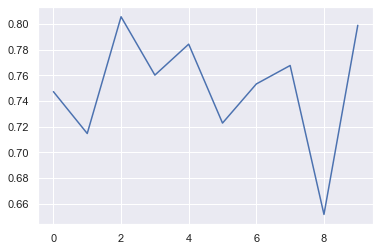

In [15]:
alpha = 5e-4
batch_size = 32
train_size = len(train_set)
K = 10
list_L = torch.zeros(K)
optimizer = optim.Adam([W_lr1, b_lr1, W_lr2, b_lr2], lr=alpha)
#torch.autograd.set_detect_anomaly(True)

train_set = np.array(train_set, dtype='object')
print(L(forward, train_set[:100], W_lr1, b_lr1, W_lr2, b_lr2))

for k in range(K):
    indices = np.random.choice(train_size, batch_size)
    
    optimizer.zero_grad()
    loss = L(forward, train_set[indices], W_lr1, b_lr1, W_lr2, b_lr2)
    loss.backward()
    optimizer.step()
    
    list_L[k] = loss.item()
    
    if k % 50 == 0:
        print(k)
        print("Loss", list_L[k])
        
        success = 0
        count = 0
        
        for line in test_set:
            x = torch.tensor([tag2ind[tag] for tag in line[0]])
            y = line[1]
            x_predict = forward(y, W_lr1, b_lr1, W_lr2, b_lr2).argmax(axis=1)
            success += (x == x_predict).sum()
            count += len(x)
        print(success / count)

plt.plot(list_L)
plt.show()

In [466]:
class MEMM(Module):
    def __init__(self):
        """
        In the constructor we instantiate four parameters and assign them as
        member parameters.
        """
        super().__init__()
        self.W_lr1 = Parameter(torch.load("TP4_functions/W_lr1.pt"))
        self.W_lr1.requires_grad_(True)
        self.b_lr1 = Parameter(torch.load("TP4_functions/b_lr1.pt"))
        self.b_lr1.requires_grad_(True)
        self.W_lr2 = Parameter(torch.load("TP4_functions/W_lr2.pt"))
        self.W_lr2.requires_grad_(True)
        self.b_lr2 = Parameter(torch.load("TP4_functions/b_lr2.pt"))
        self.b_lr2.requires_grad_(True)

    def forward(self, y):
        """
        In the forward function we accept a Tensor of input data and we must return
        a Tensor of output data. We can use Modules defined in the constructor as
        well as arbitrary operators on Tensors.
        """
        size_y = len(y)
        size_tags = len(omega_X)
        alpha = torch.zeros(size_y, size_tags)

        L1 = (y[0] @ self.W_lr1.T + self.b_lr1)
        alpha[0, :] = softmax(L1)
        
        for i in range(size_y - 1):
            x_temp = torch.diag(torch.ones(size_tags))
            y_temp = y[i+1].repeat(size_tags, 1)
            x_y = torch.cat((x_temp, y_temp), 1) 
            L2 = (x_y @ self.W_lr2.T + self.b_lr2)
            alpha[i+1, :] = alpha[i, :].clone() @ softmax(L2)

        return alpha

def ceLoss(alphas, x):
    ce = 0
    count = 0
    for i in range(len(x)):
        proba_y = torch.gather(alphas[i], 1, x[i])        
        ce -= torch.log(proba_y).sum()
        count += len(proba_y)
    
    ce /= count
    return ce

tensor(2.7028, grad_fn=<DivBackward0>)
0
Loss tensor(2.7201)
50
Loss tensor(2.2874)


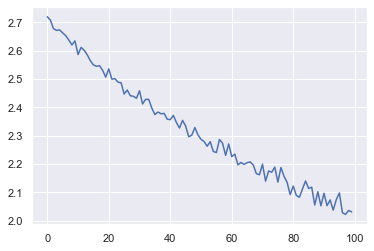

In [467]:
#torch.autograd.set_detect_anomaly(True)
step = 5e-4
batch_size = 32
train_size = len(train_set)
K = 100
list_L = torch.zeros(K)

model = MEMM()
optimizer = optim.Adam(model.parameters(), lr=step)

alphas = [model(y) for y in y_train_set[:100]]
print(CEL(alphas, x_train_set[:100]))

for k in range(K):
    
    indices = np.random.choice(train_size, batch_size)
    alphas = [model(y) for y in y_train_set[indices]]
    loss = CEL(alphas, x_train_set[indices])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    list_L[k] = loss.item()
    
    if k % 50 == 0:
        print(k)
        print("Loss", list_L[k])
        
        success = 0
        count = 0
        """
        for line in test_set:
            x = torch.tensor([tag2ind[tag] for tag in line[0]])
            y = line[1]
            x_predict = forward(y, W_lr1, b_lr1, W_lr2, b_lr2).argmax(axis=1)
            success += (x == x_predict).sum()
            count += len(x)
        print(success / count)
        """

plt.plot(list_L)
plt.show()